In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.get_arch_list())
print(torch.cuda.get_device_name(0))
torch.cuda.get_device_capability(0)
print(torch.cuda.is_available())

2.8.0+cu128
12.8
['sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']
NVIDIA GeForce RTX 5060 Laptop GPU
True


In [2]:

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

print("\nLoading CLIP model...")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()
print(f"Model loaded on: {device}")

# Test with a sample image
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

candidate_labels = ["a cat", "a dog", "a car", "a person"]

inputs = processor(text=candidate_labels, images=image, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy().flatten()

print("\nZero-shot test on sample image:")
for i, (label, prob) in enumerate(sorted(zip(candidate_labels, probs), key=lambda x: -x[1])):
    print(f"{i+1}. {label}: {prob*100:.2f}%")

c:\Users\Rain_\scoop\persist\miniconda3\envs\Jupyter\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 5060 Laptop GPU

Loading CLIP model...
Model loaded on: cuda

Zero-shot test on sample image:
1. a cat: 93.62%
2. a person: 4.08%
3. a car: 1.25%
4. a dog: 1.05%


In [ ]:
# import zipfile
# import os
# from pathlib import Path

# print(os.getcwd())

# data_dir = Path("data")
# data_dir.mkdir(exist_ok=True)

# print("\nExtracting datasets...")
# for split in ['train', 'val', 'test']:
#     zip_path = f"{split}.zip"
#     extract_path = data_dir / split
    
#     if os.path.exists(zip_path):
#         print(f"Extracting {split}.zip...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         print(f"{split} extracted to {extract_path}")
#     else:
#         print(f"{split}.zip not found")

# print("\nExtraction complete!")

d:\史雨\Study\Video_Understanding\project

Extracting datasets...
Extracting train.zip...


KeyboardInterrupt: 

In [4]:
import json
from collections import Counter

with open('data/Annotations/val.json', 'r', encoding='utf-8') as f:
    val_data = json.load(f)

print(f"\nTotal validation samples: {len(val_data)}")

answer_types = [item['answer_type'] for item in val_data]
type_counts = Counter(answer_types)

print("\nAnswer type distribution:")
for answer_type, count in type_counts.items():
    print(f"  {answer_type}: {count} ({count/len(val_data)*100:.1f}%)")

print("\nSample entry:")
sample = val_data[0]
print(f"Image: {sample['image']}")
print(f"Question: {sample['question']}")
print(f"Answerable: {sample['answerable']}")
print(f"Answer type: {sample['answer_type']}")
print(f"Answers: {sample['answers'][:3]}")


Total validation samples: 4319

Answer type distribution:
  unanswerable: 1385 (32.1%)
  other: 2691 (62.3%)
  yes/no: 195 (4.5%)
  number: 48 (1.1%)

Sample entry:
Image: VizWiz_val_00000000.jpg
Question: Ok. There is another picture I hope it is a better one.
Answerable: 0
Answer type: unanswerable
Answers: [{'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}, {'answer': 'unanswerable', 'answer_confidence': 'yes'}]


In [5]:
import random

print("\nLoading VizWiz validation data...")
answerable_data = [item for item in val_data if item['answerable'] == 1]
print(f"Found {len(answerable_data)} answerable questions\n")

num_samples = 5
samples = random.sample(answerable_data, num_samples)

print(f"Testing CLIP on {num_samples} random VizWiz images:\n")
print("="*80)

for idx, item in enumerate(samples, 1):
    image_path = Path('data/val') / item['image']
    
    if not image_path.exists():
        print(f"Sample {idx}: Image not found - {image_path}")
        continue
    
    try:
        image = Image.open(image_path).convert('RGB')
        
        print(f"\nSample {idx}:")
        print(f"Image: {item['image']}")
        print(f"Question: {item['question']}")
        
        # Ground truth answers
        answers = [ans['answer'] for ans in item['answers'] if ans['answer'] != 'unanswerable']
        if answers:
            answer_counts = {}
            for ans in answers:
                answer_counts[ans] = answer_counts.get(ans, 0) + 1
            most_common = max(answer_counts, key=answer_counts.get)
            print(f"Ground truth: {most_common} ({answer_counts[most_common]}/{len(item['answers'])} annotators)")

        # CLIP prediction (using all unique answers as candidates)
        candidate_labels = list(set(answers))
        if not candidate_labels:
            print("No valid answers to compare, skipping.")
            continue

        inputs = processor(text=candidate_labels, images=image, return_tensors="pt", padding=True).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy().flatten()
        
        # Show top-3 predictions
        top3_idx = probs.argsort()[-3:][::-1]
        print("CLIP Top 3 predictions:")
        for rank, i_ans in enumerate(top3_idx, 1):
            print(f"  {rank}. {candidate_labels[i_ans]}: {probs[i_ans]*100:.2f}%")

        print("-"*80)
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        continue

print("\nQuick CLIP test complete!")


Loading VizWiz validation data...
Found 2934 answerable questions

Testing CLIP on 5 random VizWiz images:


Sample 1:
Image: VizWiz_val_00001057.jpg
Question: What is the picture?
Ground truth: app updates (3/10 annotators)
CLIP Top 3 predictions:
  1. pending app updates on ipad: 64.64%
  2. list all apps you can update: 21.35%
  3. list apps to update: 7.20%
--------------------------------------------------------------------------------

Sample 2:
Image: VizWiz_val_00003094.jpg
Question: What color is the shirt?
Ground truth: grey (5/10 annotators)
CLIP Top 3 predictions:
  1. clothes: 72.38%
  2. beige: 17.24%
  3. brown: 5.64%
--------------------------------------------------------------------------------

Sample 3:
Image: VizWiz_val_00004045.jpg
Question: What's in this packet?
Ground truth: haribo tangfastics (3/10 annotators)
CLIP Top 3 predictions:
  1. haribo fantastics: 55.66%
  2. haribo tangfastics: 39.82%
  3. gummy candy: 2.92%
----------------------------------------

c:\Users\Rain_\scoop\persist\miniconda3\envs\Jupyter\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded 2934 answerable VizWiz samples
Using device: cuda
BLIP model loaded.



100%|██████████| 200/200 [00:18<00:00, 11.09it/s]



BLIP Evaluation Complete (200 samples)
Top-1 Accuracy: 36.50%
Top-3 Accuracy: 36.50%


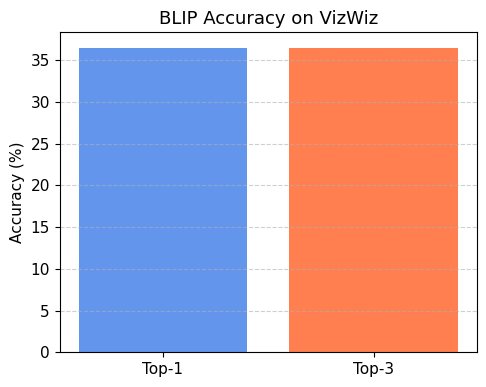

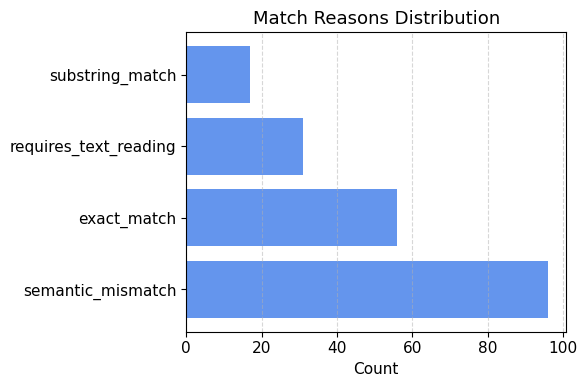

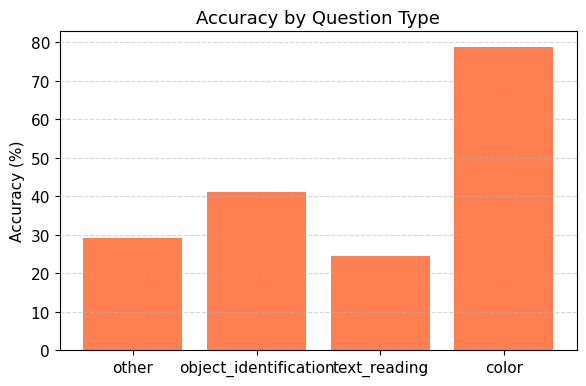

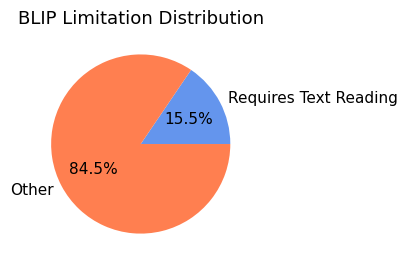

Results saved to blip_vizwiz_results.json


In [ ]:
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
from pathlib import Path
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import json
import random

# ==========================================================
# Load VizWiz validation data
# ==========================================================
val_path = Path("data/annotations/val.json")  
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

answerable_data = [item for item in val_data if item.get("answerable", 1) == 1]
print(f"Loaded {len(answerable_data)} answerable VizWiz samples")

# ==========================================================
# Initialize BLIP model
# ==========================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
model.eval()
print("BLIP model loaded.\n")

# ==========================================================
# Helper functions
# ==========================================================
def semantic_match(prediction, ground_truth, question):
    pred, gt = prediction.strip().lower(), ground_truth.strip().lower()
    if pred == gt:
        return True, 1.0, "exact_match"
    if gt in pred or pred in gt:
        return True, 0.8, "substring_match"
    if any(k in question.lower() for k in ["read", "text", "say", "screen"]):
        return False, 0.3, "requires_text_reading"
    return False, 0.5, "semantic_mismatch"

# ==========================================================
# Evaluation
# ==========================================================
results = {
    "total": 0,
    "top1_match": 0,
    "top3_match": 0,
    "match_reasons": defaultdict(int),
    "question_types": defaultdict(lambda: {"total": 0, "correct": 0}),
    "vit_cannot_answer": 0,
    "failed_predictions": []
}

num_samples = 400  
samples = random.sample(answerable_data, num_samples)
image_dir = Path("data/val")

for item in tqdm(samples):
    image_path = image_dir / item["image"]
    if not image_path.exists():
        continue
    try:
        image = Image.open(image_path).convert("RGB")
        question = item["question"]

        # ground truth
        answers = [a["answer"] for a in item["answers"] if a["answer"] != "unanswerable"]
        if not answers:
            continue
        ground_truth = Counter(answers).most_common(1)[0][0]

        # BLIP inference
        inputs = processor(images=image, text=question, return_tensors="pt").to(device)
        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=20)
        prediction = processor.decode(output[0], skip_special_tokens=True)

        # semantic match
        match, conf, reason = semantic_match(prediction, ground_truth, question)

        results["total"] += 1
        if match:
            results["top1_match"] += 1
            results["top3_match"] += 1
        results["match_reasons"][reason] += 1
        if reason == "requires_text_reading":
            results["vit_cannot_answer"] += 1

        # classify question type
        q_lower = question.lower()
        q_type = "other"
        if "color" in q_lower:
            q_type = "color"
        elif any(k in q_lower for k in ["read", "text", "say", "screen"]):
            q_type = "text_reading"
        elif "what is" in q_lower:
            q_type = "object_identification"

        results["question_types"][q_type]["total"] += 1
        if match:
            results["question_types"][q_type]["correct"] += 1

        if not match:
            results["failed_predictions"].append({
                "image": item["image"],
                "question": question,
                "ground_truth": ground_truth,
                "prediction": prediction,
                "reason": reason
            })
    except Exception as e:
        print(f"Error: {e}")
        continue

# ==========================================================
# Compute metrics
# ==========================================================
acc_top1 = results["top1_match"] / results["total"] * 100 if results["total"] else 0
acc_top3 = results["top3_match"] / results["total"] * 100 if results["total"] else 0

print(f"\nBLIP Evaluation Complete ({results['total']} samples)")
print(f"Top-1 Accuracy: {acc_top1:.2f}%")
print(f"Top-3 Accuracy: {acc_top3:.2f}%")

# ==========================================================
# Visualization (keep original color/style)
# ==========================================================
plt.rcParams.update({'font.size': 11, 'axes.titlesize': 13})
bar_color = "#6495ED"  # same blue tone as before
accent_color = "#FF7F50"

# ---  Accuracy Bar Chart ---
plt.figure(figsize=(5,4))
plt.bar(["Top-1", "Top-3"], [acc_top1, acc_top3], color=[bar_color, accent_color])
plt.ylabel("Accuracy (%)")
plt.title("BLIP Accuracy on VizWiz")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ---  Match Reason Distribution ---
plt.figure(figsize=(6,4))
reasons = list(results["match_reasons"].keys())
counts = [results["match_reasons"][r] for r in reasons]
plt.barh(reasons, counts, color=bar_color)
plt.title("Match Reasons Distribution")
plt.xlabel("Count")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---  Accuracy by Question Type ---
plt.figure(figsize=(6,4))
qtypes = list(results["question_types"].keys())
qacc = [results["question_types"][qt]["correct"]/results["question_types"][qt]["total"]*100
        if results["question_types"][qt]["total"]>0 else 0 for qt in qtypes]
plt.bar(qtypes, qacc, color=accent_color)
plt.title("Accuracy by Question Type")
plt.ylabel("Accuracy (%)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---  Limitation Pie Chart ---
plt.figure(figsize=(4,4))
plt.pie(
    [results["vit_cannot_answer"], results["total"] - results["vit_cannot_answer"]],
    labels=["Requires Text Reading", "Other"],
    autopct="%1.1f%%",
    colors=[bar_color, accent_color]
)
plt.title("BLIP Limitation Distribution")
plt.tight_layout()
plt.show()

# ==========================================================
# Save results
# ==========================================================
with open("blip_vizwiz_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2)
print("Results saved to blip_vizwiz_results.json")
